<a href="https://colab.research.google.com/github/head1ton/006_Medical_Analysis/blob/main/segmentation_models/unet_segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00


In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow as tf
import segmentation_models as sm
import albumentations as A
import numpy as np
import cv2
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `tf.keras` framework.


'tf.keras'

In [4]:
!unzip datasets.zip -d datasets

Archive:  datasets.zip
   creating: datasets/train/
  inflating: datasets/__MACOSX/._train  
  inflating: datasets/train/.DS_Store  
  inflating: datasets/__MACOSX/train/._.DS_Store  
   creating: datasets/train/images/
   creating: datasets/train/masks/
  inflating: datasets/train/images/8.png  
  inflating: datasets/__MACOSX/train/images/._8.png  
  inflating: datasets/train/images/9.png  
  inflating: datasets/__MACOSX/train/images/._9.png  
  inflating: datasets/train/images/14.png  
  inflating: datasets/__MACOSX/train/images/._14.png  
  inflating: datasets/train/images/15.png  
  inflating: datasets/__MACOSX/train/images/._15.png  
  inflating: datasets/train/images/17.png  
  inflating: datasets/__MACOSX/train/images/._17.png  
  inflating: datasets/train/images/16.png  
  inflating: datasets/__MACOSX/train/images/._16.png  
  inflating: datasets/train/images/12.png  
  inflating: datasets/__MACOSX/train/images/._12.png  
  inflating: datasets/train/images/13.png  
  inflating:

In [138]:
# Config
IMAGE_SIZE = 512
BATCH_SIZE = 6 # 8
BACKBONE = 'efficientnetb0'
CLASSES = 1
ACTIVATION = 'sigmoid'
EPOCHS = 40
LEARNING_RATE = 1e-4

In [139]:
# Model
model = sm.Unet(
    backbone_name=BACKBONE,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    classes=CLASSES,
    activation=ACTIVATION,
    encoder_weights='imagenet'
)

In [140]:
# Loss and Metrics
dice_loss = sm.losses.DiceLoss()
bce_loss = sm.losses.BinaryCELoss()
total_loss = dice_loss + bce_loss

metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(threshold=0.5),
    'accuracy'
]

In [141]:
model.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE), loss=total_loss, metrics=metrics)

In [179]:
# DataLoader
class Dataset(keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, augment=None, batch_size=BATCH_SIZE):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augment = augment
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx+1) * self.batch_size]
        batch_y = self.mask_paths[idx * self.batch_size:(idx+1) * self.batch_size]

        images, masks = [], []
        for img_path, mask_path in zip(batch_x, batch_y):
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Image not found at path: {img_path}")
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # img = img.astype(np.float32) / 255.0

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise ValueError(f"Mask not found at path: {mask_path}")
            mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
            mask = np.expand_dims(mask, axis=-1)
            mask = mask.astype(np.float32) / 255.0

            if self.augment:
                augmented = self.augment(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

            images.append(img)
            masks.append(mask)

        # print(f"[DEBUG] Batch {idx}: {len(images)} images, {len(masks)} masks")

        return np.array(images), np.array(masks)

In [180]:
def get_train_arg():
    return A.Compose([
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15),
        A.Normalize()
    ])

In [181]:
def get_val_arg():
    return A.Compose([A.Normalize()])

In [182]:
train_imgs = sorted([f"/content/datasets/train/images/{f}" for f in os.listdir("/content/datasets/train/images")])
train_masks = sorted([f"/content/datasets/train/masks/{f}" for f in os.listdir("/content/datasets/train/masks")])
val_imgs = sorted([f"/content/datasets/val/images/{f}" for f in os.listdir("/content/datasets/val/images")])
val_masks = sorted([f"/content/datasets/val/masks/{f}" for f in os.listdir("/content/datasets/val/masks")])

train_dataset = Dataset(train_imgs, train_masks, augment=get_train_arg())
val_dataset = Dataset(val_imgs, val_masks, augment=get_val_arg())

callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(patience=10, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(patience=1, monitor='val_loss', mode='min', factor=0.5)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.7044 - f1-score: 0.8008 - iou_score: 0.6677 - loss: 0.8992

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7039 - f1-score: 0.8005 - iou_score: 0.6674 - loss: 0.8994 - val_accuracy: 0.6801 - val_f1-score: 0.7903 - val_iou_score: 0.6533 - val_loss: 1.2743 - learning_rate: 5.9605e-12
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7017 - f1-score: 0.8019 - iou_score: 0.6693 - loss: 0.8952

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 898ms/step - accuracy: 0.7014 - f1-score: 0.8016 - iou_score: 0.6689 - loss: 0.8957 - val_accuracy: 0.6868 - val_f1-score: 0.7953 - val_iou_score: 0.6602 - val_loss: 1.0813 - learning_rate: 5.9605e-12
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.7076 - f1-score: 0.8026 - iou_score: 0.6703 - loss: 0.8981

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 717ms/step - accuracy: 0.7071 - f1-score: 0.8022 - iou_score: 0.6698 - loss: 0.8986 - val_accuracy: 0.6897 - val_f1-score: 0.7973 - val_iou_score: 0.6629 - val_loss: 0.9836 - learning_rate: 5.9605e-12
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.6992 - f1-score: 0.7966 - iou_score: 0.6619 - loss: 0.9047

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6996 - f1-score: 0.7970 - iou_score: 0.6626 - loss: 0.9040 - val_accuracy: 0.6914 - val_f1-score: 0.7984 - val_iou_score: 0.6644 - val_loss: 0.9283 - learning_rate: 5.9605e-12
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.7021 - f1-score: 0.7985 - iou_score: 0.6646 - loss: 0.9015

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 764ms/step - accuracy: 0.7022 - f1-score: 0.7989 - iou_score: 0.6651 - loss: 0.9009 - val_accuracy: 0.6925 - val_f1-score: 0.7990 - val_iou_score: 0.6653 - val_loss: 0.8967 - learning_rate: 5.9605e-12
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.7008 - f1-score: 0.7973 - iou_score: 0.6630 - loss: 0.9037

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7012 - f1-score: 0.7977 - iou_score: 0.6635 - loss: 0.9032 - val_accuracy: 0.6925 - val_f1-score: 0.7989 - val_iou_score: 0.6652 - val_loss: 0.8797 - learning_rate: 5.9605e-12
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7006 - f1-score: 0.7958 - iou_score: 0.6609 - loss: 0.9065

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 719ms/step - accuracy: 0.7003 - f1-score: 0.7961 - iou_score: 0.6613 - loss: 0.9056 - val_accuracy: 0.6928 - val_f1-score: 0.7992 - val_iou_score: 0.6655 - val_loss: 0.8685 - learning_rate: 5.9605e-12
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7022 - f1-score: 0.8021 - iou_score: 0.6697 - loss: 0.8945

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7021 - f1-score: 0.8021 - iou_score: 0.6696 - loss: 0.8946 - val_accuracy: 0.6923 - val_f1-score: 0.7989 - val_iou_score: 0.6651 - val_loss: 0.8628 - learning_rate: 5.9605e-12
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.7004 - f1-score: 0.7979 - iou_score: 0.6637 - loss: 0.9024

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7007 - f1-score: 0.7981 - iou_score: 0.6641 - loss: 0.9021 - val_accuracy: 0.6913 - val_f1-score: 0.7981 - val_iou_score: 0.6641 - val_loss: 0.8611 - learning_rate: 5.9605e-12
Epoch 10/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.7015 - f1-score: 0.7995 - iou_score: 0.6660 - loss: 0.8997

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7018 - f1-score: 0.7996 - iou_score: 0.6661 - loss: 0.8996 - val_accuracy: 0.6908 - val_f1-score: 0.7978 - val_iou_score: 0.6636 - val_loss: 0.8605 - learning_rate: 5.9605e-12
Epoch 11/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.7022 - f1-score: 0.7987 - iou_score: 0.6649 - loss: 0.9017 - val_accuracy: 0.6894 - val_f1-score: 0.7968 - val_iou_score: 0.6623 - val_loss: 0.8627 - learning_rate: 5.9605e-12
Epoch 12/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 0.7031 - f1-score: 0.7982 - iou_score: 0.6643 - loss: 0.9030 - val_accuracy: 0.6881 - val_f1-score: 0.7959 - val_iou_score: 0.6610 - val_loss: 0.8659 - learning_rate: 2.9802e-12
Epoch 13/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - accuracy: 0.7030 - f1-score: 0.7990 - iou_score: 0.6653 - loss: 0.9025 - val_accuracy: 0.6868 - val_f1-score: 0.7950 - val_iou_score: 0.6598 - val_loss: 0.8692 - learning_rate: 1.4901e-12
Epoch 14/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step

In [208]:
def create_mask(pred_mask):
    pred_mask = np.where(pred_mask > 0.5, 1, 0)

    return pred_mask[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Image shape: (6, 512, 512, 3), dtype: float32, min: -2.1007792949676514, max: 2.6051416397094727
Mask shape: (6, 512, 512, 1), dtype: float32, min: 0.0, max: 1.0
pred shape: (6, 512, 512, 1), dtype: float32, min: 0.011551924981176853, max: 0.9976524710655212


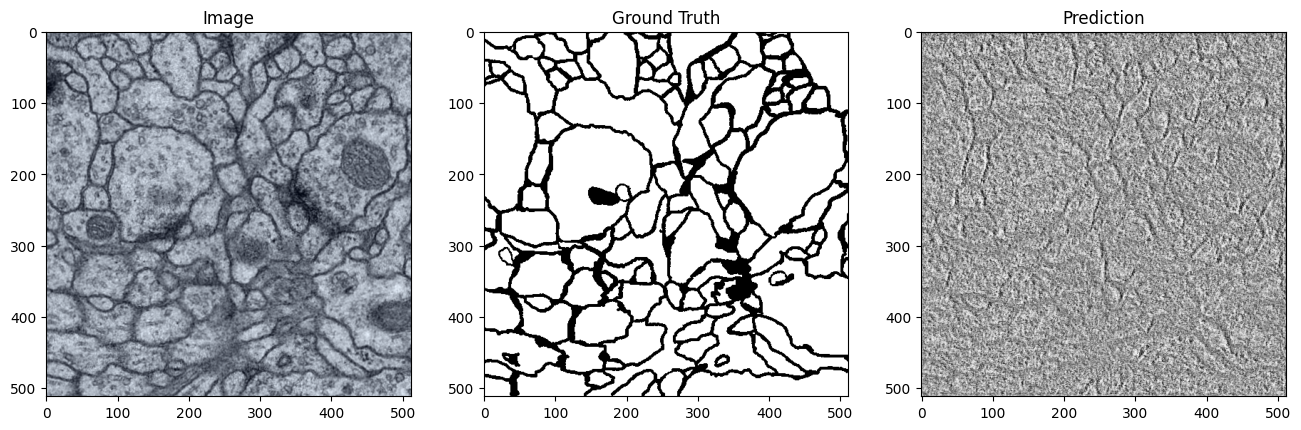

In [221]:
import matplotlib.pyplot as plt

def visualize(img, mask, pred):
    plt.figure(figsize=(16,8))
    plt.subplot(1,3,1); plt.imshow(keras.preprocessing.image.array_to_img(img)); plt.title("Image")
    plt.subplot(1,3,2); plt.imshow(keras.preprocessing.image.array_to_img(mask), cmap='gray'); plt.title("Ground Truth")
    plt.subplot(1,3,3); plt.imshow(keras.preprocessing.image.array_to_img(pred), cmap='gray'); plt.title("Prediction")
    plt.show()


img, mask = val_dataset[0]
pred = model.predict(img)

# pred = np.where(pred > 0.5, 1, 0)

print(f"Image shape: {img.shape}, dtype: {img.dtype}, min: {img.min()}, max: {img.max()}")
print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}, min: {mask.min()}, max: {mask.max()}")
print(f"pred shape: {pred.shape}, dtype: {pred.dtype}, min: {pred.min()}, max: {pred.max()}")

visualize(img[0], mask[0], pred[0])